In [1]:
# ____LOAD DATA____

import datetime
import scipy
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
import numpy as np
import pandas as pd 
import seaborn as sns

train_data = np.load('data_train.pkl', allow_pickle=True)
train_data = np.array(train_data)
train_data = train_data.T
train_data = pd.DataFrame(train_data, columns=['text','category'])

test_data = np.load('data_test.pkl', allow_pickle=True)
test_data = np.array(test_data)
test_data = pd.DataFrame(test_data, columns=['text'])

In [2]:
# slight class imbalance
train_data.groupby('category').nunique()

,text,category
category,,
AskReddit,3487,1
GlobalOffensive,3404,1
Music,3229,1
Overwatch,3443,1
anime,3495,1
baseball,3495,1
canada,3499,1
conspiracy,3484,1
europe,3494,1


In [3]:
# ____TEXT PREPROCESSING____

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
stemmer = PorterStemmer()

STOPWORDS = set(stopwords.words('english'))

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
# function to lemmatize sentences
def lemmatize_sentence(sentence):
    # tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    # tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


def clean_text(text):
    text = tokenizer.tokenize(text)
    
    # remove all non-alphabetic terms
    text = [word for word in text if word.isalpha()]
    
    # remove all stopwords
    text = ' '.join(word for word in text if word not in STOPWORDS)
    
    # lemmatize words
    text = lemmatize_sentence(text)
    
    # stemming
    text = tokenizer.tokenize(text)
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    
    return text


train_data.text = train_data.text.str.lower()
train_data.text = train_data.text.apply(clean_text)

test_data.text = test_data.text.str.lower()
test_data.text = test_data.text.apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\draby\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# split the training data into training and validation sets
from sklearn import model_selection

x_test = test_data.text

x_train, x_valid, y_train, y_valid = model_selection.train_test_split(train_data.text, train_data.category, test_size=0.2, random_state=0)

# reset indices
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

In [5]:
# ____TEXT FEATURE ENGINEERING____

from sklearn import model_selection, preprocessing, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from scipy.sparse import csr_matrix, hstack
import re

# Function to vectorize the predictive features
# Removes by default the terms that appear in 90% or more documents.
def feature_engineering(train, valid, test, maxdf = 0.8, mindf = 0, type='cv'):
    vocab = pd.concat([train_data.text, test_data.text])
    
    if type == 'cv':
        vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_df = maxdf, min_df = mindf)
    elif type == 'tfidf':
        vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_df = maxdf, min_df = mindf)
    elif type == 'tfidf_ng':
        vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,2), max_df = maxdf, min_df = mindf, max_features=50000)
    
    vect.fit(vocab)
    train_vect = vect.transform(train)
    train_vect = csr_matrix(train_vect)
    
    valid_vect = vect.transform(valid)
    valid_vect = csr_matrix(valid_vect)
    
    test_vect = vect.transform(test)
    test_vect = csr_matrix(test_vect)
        
    if type == 'cv':
        return train_vect, valid_vect, test_vect, vect.get_feature_names()
    else:
        return train_vect, valid_vect, test_vect

In [6]:
# We vectorize the predictive features in 3 different ways and will test them on the models during model selection to find the
# most effective.

# ____COUNT VECTORS____
x_train_count_vector, x_valid_count_vector, x_test_count_vector, feature_names = feature_engineering(x_train, x_valid, x_test, type = 'cv')

# ____WORD LEVEL TF-IDF____
x_train_tfidf_word, x_valid_tfidf_word, x_test_tfidf_word = feature_engineering(x_train, x_valid, x_test, type = 'tfidf')

# ____N-GRAM LEVEL TF-IDF____ 
x_train_tfidf_ngram, x_valid_tfidf_ngram, x_test_tfidf_ngram = feature_engineering(x_train, x_valid, x_test, type = 'tfidf_ng')

In [97]:
# ____MODEL SELECTION____

# Scoring metric for model tuning and model selection
from sklearn.metrics import make_scorer

scorer = metrics.make_scorer(metrics.f1_score, average = 'macro')

In [40]:
# Sampling function that returns a sample of the dataset for the various types of vectorized features used.
import random
from random import sample

def sampling(fraction_of_dataset, type = 'reg'):
    
    if type == 'word_embeddings':
        # Only use a sample of the dataset during model selection for faster training
        sample_y_emb = y.sample(frac = fraction_of_dataset) 
        sample_x_emb = seq_x[list(sample_y_emb.index), :]
        
        # Split the sample dataset into training and test datasets 
        train_x_emb, test_x_emb, train_y_emb, test_y_emb = model_selection.train_test_split(sample_x_emb, sample_y_emb)
        
        return train_x_emb, test_x_emb, train_y_emb, test_y_emb
    
    elif type == 'reg': 
        # Only use a sample of the dataset during model selection for faster training
        sample_y = y_train.sample(frac = fraction_of_dataset) 
        sample_x_cv = x_train_count_vector[list(sample_y.index), :]
        sample_x_tfidf = x_train_tfidf_word[list(sample_y.index), :]
        sample_x_tfidf_ng = x_train_tfidf_ngram[list(sample_y.index), :]
    
        return sample_x_cv, sample_x_tfidf, sample_x_tfidf_ng, sample_y

In [41]:
# Training and testing function for all models

def train_model(classifier, x_train, y_train, x_valid, y_valid, is_neural_net=False):
    
    # Fit the training dataset on the classifier
    history = classifier.fit(x_train, y_train)
    
    # Predict the labels on test dataset
    predictions = classifier.predict(x_valid)
    
    if is_neural_net:
        y_valid = y_valid.argmax(axis=-1)
        labs = list(encoder.classes_)
    else:
        labs = classifier.classes_
    
    # Show a classification report as well as a confusion matrix
    print(metrics.classification_report(y_valid, predictions, target_names = labs))

    cm = metrics.confusion_matrix(y_valid, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, xticklabels = labs , yticklabels = labs , annot=True).set_title('Matrice de confusion')
    
    return history

In [98]:
# Tuning function for all models

from sklearn.model_selection import GridSearchCV

def tuning(model, parameters, cross_val, num_jobs, feature_types):
    
    graph_info = []
    
    for feature in feature_types: 
        if feature == 'cv':
            print('--' + 'Tuning on Count Vectors' + '--')
            train_x = sample_x_cv; train_y = sample_y
        elif feature == 'tfidf':
            print('--' + 'Tuning on Word Level TF-IDF Vectors' + '--')
            train_x = sample_x_tfidf; train_y = sample_y
        elif feature == 'tfidf_ng':
            print('--' + 'Tuning on N-gram Level TF-IDF Vectors' + '--')
            train_x = sample_x_tfidf_ng; train_y = sample_y

        tune = GridSearchCV(model, parameters, cv=cross_val, scoring = scorer, n_jobs = num_jobs)
        tune.fit(train_x, train_y)
        
        # Show the best hyper-parameters and macro-averaged f1 score for the best tuning option
        print("Best hyper-parameters: ", tune.best_params_)
        print("Best macro-averaged f1 score: ", tune.best_score_, "\n")    
        test = tune.cv_results_
        print("Results: ", tune.cv_results_['params'], "\n")
        print("Results: ", tune.cv_results_['mean_test_score'], "\n")
        graph_info.append(tune.cv_results_['params'])
        graph_info.append(tune.cv_results_['mean_test_score'])
    
    return graph_info

In [99]:
# ____MODEL TUNING & SELECTION____

# NAIVE BAYES TUNING
from sklearn import naive_bayes

# We can use the entire dataset since this algorithm computes fast
sample_x_cv, sample_x_tfidf, sample_x_tfidf_ng, sample_y = sampling(1.0)

# Hyper-parameters to tune
parameters = {'alpha':[0.01, 0.05, 0.1, 0.15, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.6, 0.8, 1, 1.2, 1.5, 2, 3, 4, 5]}

# Tuning the model
model_NB = naive_bayes.MultinomialNB()
graph_NB = tuning(model_NB, parameters, 10, 1, ['cv', 'tfidf', 'tfidf_ng'])

--Tuning on Count Vectors--
Best hyper-parameters:  {'alpha': 0.18}
Best macro-averaged f1 score:  0.556868177502576 

Results:  [{'alpha': 0.01}, {'alpha': 0.05}, {'alpha': 0.1}, {'alpha': 0.15}, {'alpha': 0.18}, {'alpha': 0.2}, {'alpha': 0.25}, {'alpha': 0.3}, {'alpha': 0.35}, {'alpha': 0.4}, {'alpha': 0.6}, {'alpha': 0.8}, {'alpha': 1}, {'alpha': 1.2}, {'alpha': 1.5}, {'alpha': 2}, {'alpha': 3}, {'alpha': 4}, {'alpha': 5}] 

Results:  [0.54738709 0.55429431 0.55655232 0.55664244 0.55686818 0.55655382
 0.55613123 0.55544752 0.55471364 0.55413346 0.54941923 0.54439632
 0.53989952 0.53453376 0.52817797 0.5188538  0.50357074 0.49040011
 0.48102874] 

--Tuning on Word Level TF-IDF Vectors--
Best hyper-parameters:  {'alpha': 0.15}
Best macro-averaged f1 score:  0.5669621661987854 

Results:  [{'alpha': 0.01}, {'alpha': 0.05}, {'alpha': 0.1}, {'alpha': 0.15}, {'alpha': 0.18}, {'alpha': 0.2}, {'alpha': 0.25}, {'alpha': 0.3}, {'alpha': 0.35}, {'alpha': 0.4}, {'alpha': 0.6}, {'alpha': 0.8}, {

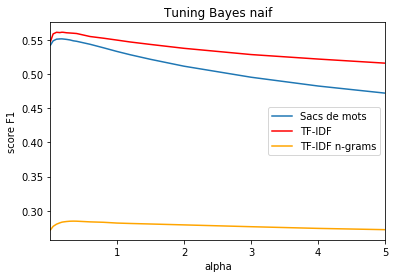

In [72]:
# plot results
cv = pd.concat([pd.DataFrame(graph_NB[0]), pd.DataFrame(graph_NB[1])], axis=1)
tfidf = pd.concat([pd.DataFrame(graph_NB[2]), pd.DataFrame(graph_NB[3])], axis=1)
tfidf_ng = pd.concat([pd.DataFrame(graph_NB[4]), pd.DataFrame(graph_NB[5])], axis=1)

ax = plt.gca()
cv.plot(kind='line',x='alpha',y=0,ax=ax)
tfidf.plot(kind='line',x='alpha',y=0, color='red', ax=ax)
tfidf_ng.plot(kind='line',x='alpha',y=0, color='orange', ax=ax)

plt.legend(['Sacs de mots','TF-IDF','TF-IDF n-grams'])
plt.ylabel('score F1')
plt.title('Tuning Bayes naif')
plt.show()

                 precision    recall  f1-score   support

      AskReddit       0.26      0.30      0.28       737
GlobalOffensive       0.62      0.61      0.62       669
          Music       0.59      0.66      0.62       687
      Overwatch       0.62      0.71      0.66       691
          anime       0.62      0.62      0.62       682
       baseball       0.72      0.59      0.65       714
         canada       0.40      0.52      0.45       645
     conspiracy       0.39      0.45      0.42       723
         europe       0.50      0.52      0.51       667
          funny       0.23      0.15      0.19       724
  gameofthrones       0.76      0.71      0.73       711
         hockey       0.68      0.60      0.64       715
leagueoflegends       0.75      0.62      0.68       725
         movies       0.56      0.59      0.57       713
            nba       0.67      0.66      0.66       658
            nfl       0.65      0.61      0.63       701
         soccer       0.75    

MultinomialNB(alpha=0.18, class_prior=None, fit_prior=True)

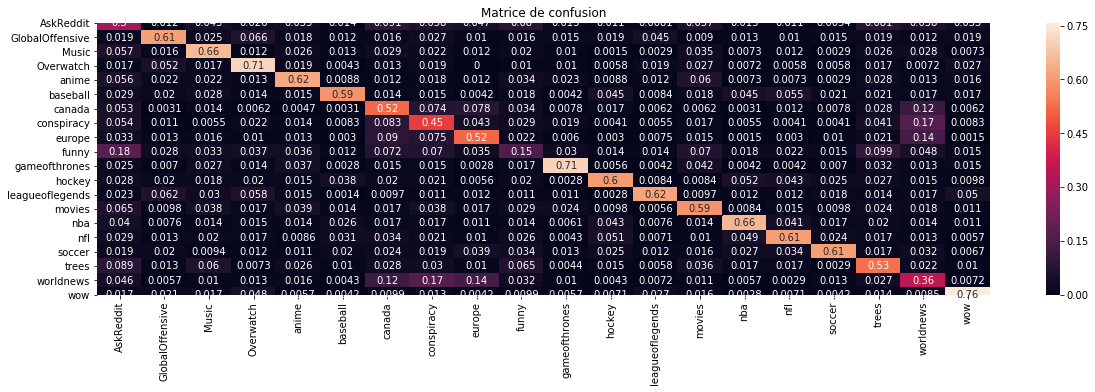

In [100]:
# NAIVE BAYES TRAINING & VALIDATION
train_model(model_NB.set_params(alpha = 0.18), x_train_tfidf_word, y_train, x_valid_tfidf_word, y_valid)

In [115]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

pred = model_NB.predict(x_valid_tfidf_word)

print('Precision (macro-avg): ',  precision_score(y_valid, pred, average = 'macro'))
print('Recall (macro-avg): ',  recall_score(y_valid, pred, average = 'macro'))
print('F1 Score (macro-avg): ',  f1_score(y_valid, pred, average = 'macro'))
print('Accuracy: ',  accuracy_score(y_valid, pred))

Precision (macro-avg):  0.5657026073639786
Recall (macro-avg):  0.5591891346060481
F1 Score (macro-avg):  0.5598018902262822
Accuracy:  0.5578571428571428


In [118]:
# LOGISTIC REGRESSION TUNING
from sklearn.linear_model import LogisticRegression

# Sample size for tuning
sample_x_cv, sample_x_tfidf, sample_x_tfidf_ng, sample_y = sampling(0.1)

# Hyper-parameters to tune
parameters = {'solver': ['newton-cg','lbfgs', 'sag', 'saga'] ,'C':[0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]}

# Tuning the model
model_LR = LogisticRegression(multi_class='multinomial', n_jobs=-1)
graph_LR = tuning(model_LR, parameters, 5, 10, ['cv', 'tfidf', 'tfidf_ng'])

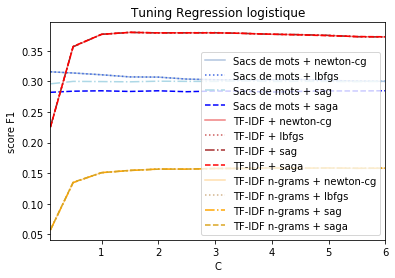

In [108]:
# plot results
cv = pd.concat([pd.DataFrame(graph_LR[0]), pd.DataFrame(graph_LR[1])], axis=1)
tfidf = pd.concat([pd.DataFrame(graph_LR[2]), pd.DataFrame(graph_LR[3])], axis=1)
tfidf_ng = pd.concat([pd.DataFrame(graph_LR[4]), pd.DataFrame(graph_LR[5])], axis=1)

ax = plt.gca()
cv[cv.solver == 'newton-cg'].plot(kind='line',x='C',y=0, color='lightsteelblue', ax=ax)
cv[cv.solver == 'lbfgs'].plot(kind='line',x='C',y=0, color='royalblue', linestyle=':', ax=ax)
cv[cv.solver == 'sag'].plot(kind='line',x='C',y=0, color='lightblue', linestyle='-.', ax=ax)
cv[cv.solver == 'saga'].plot(kind='line',x='C',y=0, color='blue', linestyle='--',ax=ax)

tfidf[tfidf.solver == 'newton-cg'].plot(kind='line',x='C',y=0, color='lightcoral', ax=ax)
tfidf[tfidf.solver == 'lbfgs'].plot(kind='line',x='C',y=0, color='indianred', linestyle=':', ax=ax)
tfidf[tfidf.solver == 'sag'].plot(kind='line',x='C',y=0, color='brown', linestyle='-.', ax=ax)
tfidf[tfidf.solver == 'saga'].plot(kind='line',x='C',y=0, color='red', linestyle='--',ax=ax)

tfidf_ng[tfidf_ng.solver == 'newton-cg'].plot(kind='line',x='C',y=0, color='navajowhite', ax=ax)
tfidf_ng[tfidf_ng.solver == 'lbfgs'].plot(kind='line',x='C',y=0, color='tan', linestyle=':', ax=ax)
tfidf_ng[tfidf_ng.solver == 'sag'].plot(kind='line',x='C',y=0, color='orange', linestyle='-.', ax=ax)
tfidf_ng[tfidf_ng.solver == 'saga'].plot(kind='line',x='C',y=0, color='goldenrod', linestyle='--',ax=ax)

plt.legend(['Sacs de mots + newton-cg','Sacs de mots + lbfgs', 'Sacs de mots + sag', 'Sacs de mots + saga','TF-IDF + newton-cg', 'TF-IDF + lbfgs','TF-IDF + sag', 'TF-IDF + saga', 'TF-IDF n-grams + newton-cg', 'TF-IDF n-grams + lbfgs', 'TF-IDF n-grams + sag', 'TF-IDF n-grams + saga'], loc='lower right')
plt.ylabel('score F1')
plt.title('Tuning Regression logistique')
plt.show()

                 precision    recall  f1-score   support

      AskReddit       0.25      0.27      0.26       737
GlobalOffensive       0.58      0.60      0.59       669
          Music       0.66      0.65      0.65       687
      Overwatch       0.74      0.63      0.68       691
          anime       0.55      0.58      0.56       682
       baseball       0.64      0.59      0.61       714
         canada       0.46      0.46      0.46       645
     conspiracy       0.39      0.41      0.40       723
         europe       0.47      0.53      0.50       667
          funny       0.19      0.27      0.23       724
  gameofthrones       0.79      0.69      0.74       711
         hockey       0.62      0.57      0.59       715
leagueoflegends       0.67      0.61      0.64       725
         movies       0.62      0.55      0.58       713
            nba       0.64      0.60      0.62       658
            nfl       0.64      0.56      0.60       701
         soccer       0.66    

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

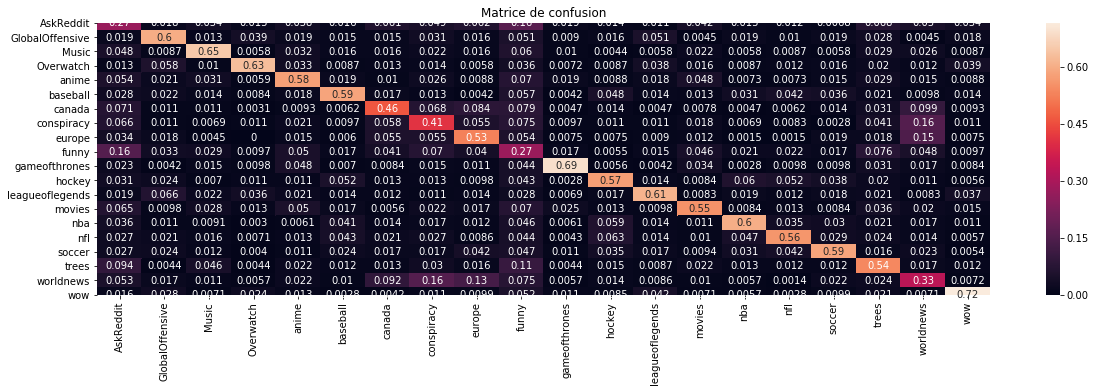

In [119]:
# LOGISTIC REGRESSION TRAINING & VALIDATION
train_model(model_LR.set_params(solver = 'lbfgs', C = 1.5), x_train_tfidf_word, y_train, x_valid_tfidf_word, y_valid)

In [120]:
pred = model_LR.predict(x_valid_tfidf_word)

print('Precision (macro-avg): ',  precision_score(y_valid, pred, average = 'macro'))
print('Recall (macro-avg): ',  recall_score(y_valid, pred, average = 'macro'))
print('F1 Score (macro-avg): ',  f1_score(y_valid, pred, average = 'macro'))
print('Accuracy: ',  accuracy_score(y_valid, pred))

Precision (macro-avg):  0.5545710221694808
Recall (macro-avg):  0.5373103787491856
F1 Score (macro-avg):  0.5444044772198715
Accuracy:  0.5363571428571429


In [121]:
# KNN TUNING
from sklearn.neighbors import KNeighborsClassifier

# Sample size for tuning
sample_x_cv, sample_x_tfidf, sample_x_tfidf_ng, sample_y = sampling(1)

# Hyper-parameters to tune
parameters = {'n_neighbors':[80, 90, 100, 110, 120, 130, 140, 150, 160], 'weights':['distance', 'uniform']}

# Tuning the model
model_KNN = KNeighborsClassifier(algorithm='auto', n_jobs=-1)
graph_KNN = tuning(model_KNN, parameters, 10, 10, ['cv','tfidf', 'tfidf_ng'])

In [102]:
# plot results
cv = pd.concat([pd.DataFrame(graph_KNN[0]), pd.DataFrame(graph_KNN[1])], axis=1)
tfidf = pd.concat([pd.DataFrame(graph_KNN[2]), pd.DataFrame(graph_KNN[3])], axis=1)
tfidf_ng = pd.concat([pd.DataFrame(graph_KNN[4]), pd.DataFrame(graph_KNN[5])], axis=1)

ax = plt.gca()
cv[cv.weights == 'distance'].plot(kind='line',x='n_neighbors',y=0, color='lightblue', ax=ax)
cv[cv.weights == 'uniform'].plot(kind='line',x='n_neighbors',y=0, color='royalblue', linestyle=':', ax=ax)

tfidf[tfidf.weights == 'distance'].plot(kind='line',x='n_neighbors',y=0, color='lightcoral', ax=ax)
tfidf[tfidf.weights == 'uniform'].plot(kind='line',x='n_neighbors',y=0, color='red', linestyle=':', ax=ax)

tfidf_ng[tfidf_ng.weights == 'distance'].plot(kind='line',x='n_neighbors',y=0, color='navajowhite', ax=ax)
tfidf_ng[tfidf_ng.weights == 'uniform'].plot(kind='line',x='n_neighbors',y=0, color='orange', linestyle=':', ax=ax)

plt.legend(['Sacs de mots + vote pondere','Sacs de mots + vote uniforme','TF-IDF + vote pondere', 'TF-IDF + vote uniforme', 'TF-IDF n-grams + vote pondere', 'TF-IDF n-grams + vote uniforme'], loc='center left')
plt.ylabel('score F1')
plt.xlabel('k voisins')
plt.title('Tuning KNN')
plt.show()

NameError: name 'graph_KNN' is not defined

                 precision    recall  f1-score   support

      AskReddit       0.24      0.17      0.20       737
GlobalOffensive       0.43      0.60      0.50       669
          Music       0.53      0.65      0.58       687
      Overwatch       0.55      0.67      0.60       691
          anime       0.48      0.50      0.49       682
       baseball       0.60      0.53      0.56       714
         canada       0.44      0.42      0.43       645
     conspiracy       0.45      0.31      0.37       723
         europe       0.49      0.43      0.46       667
          funny       0.19      0.20      0.19       724
  gameofthrones       0.68      0.67      0.68       711
         hockey       0.59      0.52      0.56       715
leagueoflegends       0.62      0.55      0.58       725
         movies       0.47      0.55      0.51       713
            nba       0.50      0.58      0.54       658
            nfl       0.52      0.53      0.53       701
         soccer       0.64    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=120, p=2,
                     weights='distance')

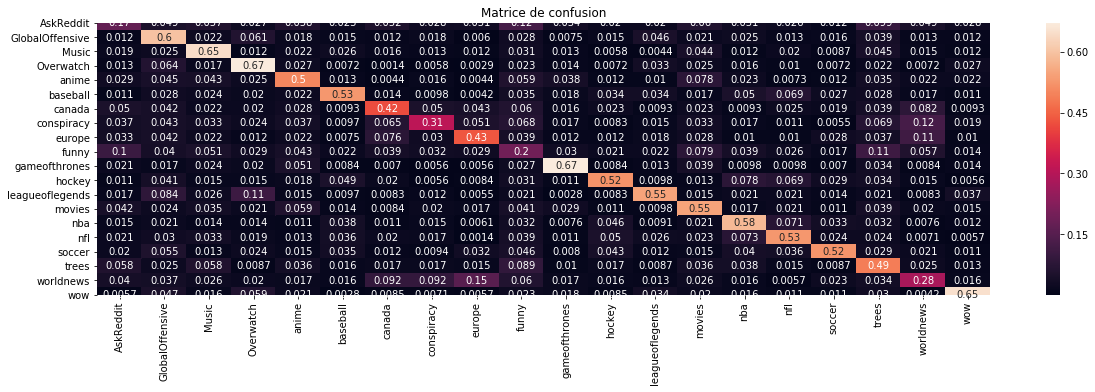

In [122]:
# KNN TRAINING & TESTING
train_model(model_KNN.set_params(n_neighbors = 120, weights = 'distance'), x_train_tfidf_word, y_train, x_valid_tfidf_word, y_valid)

In [123]:
pred = model_KNN.predict(x_valid_tfidf_word)

print('Precision (macro-avg): ',  precision_score(y_valid, pred, average = 'macro'))
print('Recall (macro-avg): ',  recall_score(y_valid, pred, average = 'macro'))
print('F1 Score (macro-avg): ',  f1_score(y_valid, pred, average = 'macro'))
print('Accuracy: ',  accuracy_score(y_valid, pred))

Precision (macro-avg):  0.49057142062553416
Recall (macro-avg):  0.49100823044032904
F1 Score (macro-avg):  0.487126442594466
Accuracy:  0.48957142857142855


In [127]:
# RANDOM FOREST TUNING
from sklearn.ensemble import RandomForestClassifier
test=[]
# Sample size for tuning
sample_x_cv, sample_x_tfidf, sample_x_tfidf_ng, sample_y = sampling(0.1)

# Hyper-parameters to tune
parameters = {'n_estimators':[100, 500, 1000, 2000], 'oob_score':[True], 'max_depth':[75, 100, 125, 150, 200, 300,500, None]}

# Tuning the model
model_RF = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 0)
graph_RF = tuning(model_RF, parameters, 3, 10, ['cv','tfidf', 'tfidf_ng'])

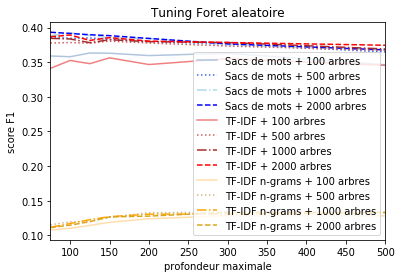

In [152]:
# plot results
cv = pd.concat([pd.DataFrame(graph_RF[0]), pd.DataFrame(graph_RF[1])], axis=1)
tfidf = pd.concat([pd.DataFrame(graph_RF[2]), pd.DataFrame(graph_RF[3])], axis=1)
tfidf_ng = pd.concat([pd.DataFrame(graph_RF[4]), pd.DataFrame(graph_RF[5])], axis=1)

ax = plt.gca()
cv[cv.n_estimators == 100].plot(kind='line',x='max_depth',y=0, color='lightsteelblue', ax=ax)
cv[cv.n_estimators == 500].plot(kind='line',x='max_depth',y=0, color='royalblue', linestyle=':', ax=ax)
cv[cv.n_estimators == 1000].plot(kind='line',x='max_depth',y=0, color='lightblue', linestyle='-.', ax=ax)
cv[cv.n_estimators == 2000].plot(kind='line',x='max_depth',y=0, color='blue', linestyle='--',ax=ax)

tfidf[tfidf.n_estimators == 100].plot(kind='line',x='max_depth',y=0, color='lightcoral', ax=ax)
tfidf[tfidf.n_estimators == 500].plot(kind='line',x='max_depth',y=0, color='indianred', linestyle=':', ax=ax)
tfidf[tfidf.n_estimators == 1000].plot(kind='line',x='max_depth',y=0, color='brown', linestyle='-.', ax=ax)
tfidf[tfidf.n_estimators == 2000].plot(kind='line',x='max_depth',y=0, color='red', linestyle='--',ax=ax)

tfidf_ng[tfidf_ng.n_estimators == 100].plot(kind='line',x='max_depth',y=0, color='navajowhite', ax=ax)
tfidf_ng[tfidf_ng.n_estimators == 500].plot(kind='line',x='max_depth',y=0, color='tan', linestyle=':', ax=ax)
tfidf_ng[tfidf_ng.n_estimators == 1000].plot(kind='line',x='max_depth',y=0, color='orange', linestyle='-.', ax=ax)
tfidf_ng[tfidf_ng.n_estimators == 2000].plot(kind='line',x='max_depth',y=0, color='goldenrod', linestyle='--',ax=ax)

plt.legend(['Sacs de mots + 100 arbres','Sacs de mots + 500 arbres', 'Sacs de mots + 1000 arbres', 'Sacs de mots + 2000 arbres','TF-IDF + 100 arbres', 'TF-IDF + 500 arbres','TF-IDF + 1000 arbres', 'TF-IDF + 2000 arbres', 'TF-IDF n-grams + 100 arbres', 'TF-IDF n-grams + 500 arbres', 'TF-IDF n-grams + 1000 arbres', 'TF-IDF n-grams + 2000 arbres'], loc='lower right')
plt.ylabel('score F1')
plt.xlabel('profondeur maximale')
plt.title('Tuning Foret aleatoire')
plt.show()

                 precision    recall  f1-score   support

      AskReddit       0.29      0.12      0.17       737
GlobalOffensive       0.53      0.50      0.51       669
          Music       0.68      0.61      0.64       687
      Overwatch       0.70      0.59      0.64       691
          anime       0.48      0.52      0.50       682
       baseball       0.71      0.44      0.54       714
         canada       0.52      0.38      0.44       645
     conspiracy       0.48      0.27      0.35       723
         europe       0.40      0.51      0.45       667
          funny       0.11      0.53      0.18       724
  gameofthrones       0.79      0.66      0.72       711
         hockey       0.58      0.45      0.50       715
leagueoflegends       0.57      0.46      0.51       725
         movies       0.67      0.47      0.55       713
            nba       0.65      0.45      0.53       658
            nfl       0.52      0.48      0.50       701
         soccer       0.67    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=75, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3000,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

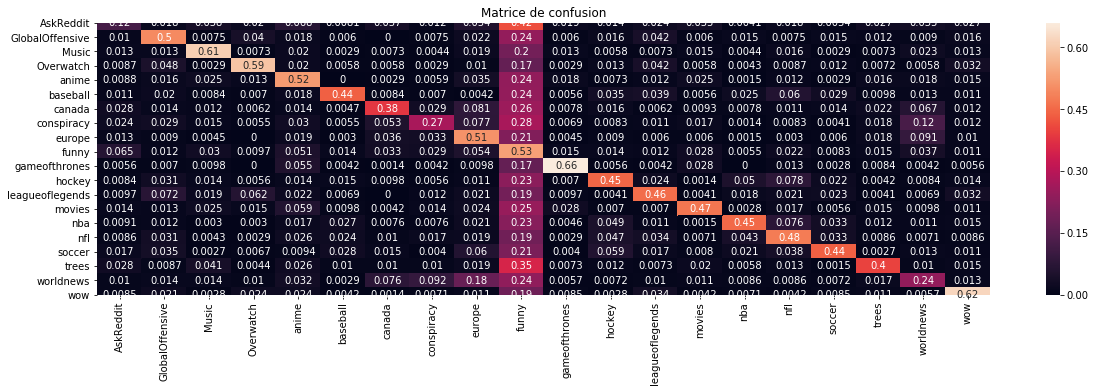

In [128]:
# RANDOM FOREST TRAINING & VALIDATION
train_model(model_RF.set_params(n_estimators = 3000, oob_score = True, max_depth = 75), x_train_count_vector, y_train, x_valid_count_vector, y_valid)

In [129]:
pred = model_RF.predict(x_valid_tfidf_word)

print('Precision (macro-avg): ',  precision_score(y_valid, pred, average = 'macro'))
print('Recall (macro-avg): ',  recall_score(y_valid, pred, average = 'macro'))
print('F1 Score (macro-avg): ',  f1_score(y_valid, pred, average = 'macro'))
print('Accuracy: ',  accuracy_score(y_valid, pred))

Precision (macro-avg):  0.6104066619264767
Recall (macro-avg):  0.09153732210077034
F1 Score (macro-avg):  0.0843027013830697
Accuracy:  0.093


In [19]:
# MLP (sklearn) TUNING
from sklearn.neural_network import MLPClassifier

# Sample size for tuning
sample_x_cv, sample_x_tfidf, sample_x_tfidf_ng, sample_y = sampling(0.1)

# Hyper-parameters to tune
parameters = {'learning_rate_init':[0.001], 'hidden_layer_sizes':[(50,), (100,), (300,), (500,)], 'activation': ['logistic'], 'alpha': [0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]}

# Tuning the model
model_MLP = MLPClassifier(solver = 'adam', random_state = 0, early_stopping = True, max_iter = 300, n_iter_no_change = 10)
graph_MLP = tuning(model_MLP, parameters, 2, 10, ['cv','tfidf', 'tfidf_ng'])

--Tuning on Count Vectors--
Best hyper-parameters:  {'activation': 'logistic', 'alpha': 1e-07, 'hidden_layer_sizes': (300,), 'learning_rate_init': 0.001}
Best macro-averaged f1 score:  0.385060615406691 

Results:  [{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}, {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}, {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (300,), 'learning_rate_init': 0.001}, {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (500,), 'learning_rate_init': 0.001}, {'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}, {'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}, {'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': (300,), 'learning_rate_init': 0.001}, {'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_size

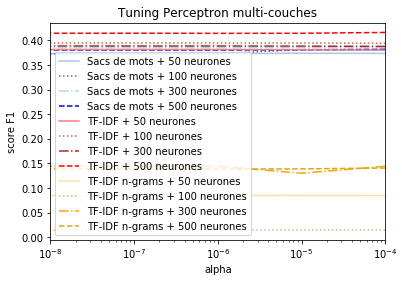

In [35]:
# plot results
cv = pd.concat([pd.DataFrame(graph_MLP[0]), pd.DataFrame(graph_MLP[1])], axis=1)
tfidf = pd.concat([pd.DataFrame(graph_MLP[2]), pd.DataFrame(graph_MLP[3])], axis=1)
tfidf_ng = pd.concat([pd.DataFrame(graph_MLP[4]), pd.DataFrame(graph_MLP[5])], axis=1)

ax = plt.gca()
cv[cv.hidden_layer_sizes == (50,)].plot(kind='line',x='alpha',y=0, color='lightsteelblue', ax=ax)
cv[cv.hidden_layer_sizes == (100,)].plot(kind='line',x='alpha',y=0, color='royalblue', linestyle=':', ax=ax)
cv[cv.hidden_layer_sizes == (300,)].plot(kind='line',x='alpha',y=0, color='lightblue', linestyle='-.', ax=ax)
cv[cv.hidden_layer_sizes == (500,)].plot(kind='line',x='alpha',y=0, color='blue', linestyle='--',ax=ax)

tfidf[tfidf.hidden_layer_sizes == (50,)].plot(kind='line',x='alpha',y=0, color='lightcoral', ax=ax)
tfidf[tfidf.hidden_layer_sizes == (100,)].plot(kind='line',x='alpha',y=0, color='indianred', linestyle=':', ax=ax)
tfidf[tfidf.hidden_layer_sizes == (300,)].plot(kind='line',x='alpha',y=0, color='brown', linestyle='-.', ax=ax)
tfidf[tfidf.hidden_layer_sizes == (500,)].plot(kind='line',x='alpha',y=0, color='red', linestyle='--',ax=ax)

tfidf_ng[tfidf_ng.hidden_layer_sizes == (50,)].plot(kind='line',x='alpha',y=0, color='navajowhite', ax=ax)
tfidf_ng[tfidf_ng.hidden_layer_sizes == (100,)].plot(kind='line',x='alpha',y=0, color='tan', linestyle=':', ax=ax)
tfidf_ng[tfidf_ng.hidden_layer_sizes == (300,)].plot(kind='line',x='alpha',y=0, color='orange', linestyle='-.', ax=ax)
tfidf_ng[tfidf_ng.hidden_layer_sizes == (500,)].plot(kind='line',x='alpha',y=0, color='goldenrod', linestyle='--',ax=ax)

plt.legend(['Sacs de mots + 50 neurones','Sacs de mots + 100 neurones', 'Sacs de mots + 300 neurones', 'Sacs de mots + 500 neurones','TF-IDF + 50 neurones', 'TF-IDF + 100 neurones','TF-IDF + 300 neurones', 'TF-IDF + 500 neurones', 'TF-IDF n-grams + 50 neurones', 'TF-IDF n-grams + 100 neurones', 'TF-IDF n-grams + 300 neurones', 'TF-IDF n-grams + 500 neurones'], loc='lower left')
plt.ylabel('score F1')
plt.xlabel('alpha')
plt.title('Tuning Perceptron multi-couches')
plt.xscale('log')
plt.show()

                 precision    recall  f1-score   support

      AskReddit       0.31      0.25      0.27       737
GlobalOffensive       0.62      0.63      0.63       669
          Music       0.69      0.68      0.69       687
      Overwatch       0.76      0.68      0.72       691
          anime       0.62      0.63      0.63       682
       baseball       0.69      0.62      0.65       714
         canada       0.53      0.49      0.51       645
     conspiracy       0.46      0.43      0.45       723
         europe       0.50      0.56      0.53       667
          funny       0.18      0.34      0.24       724
  gameofthrones       0.81      0.73      0.77       711
         hockey       0.65      0.61      0.63       715
leagueoflegends       0.66      0.67      0.66       725
         movies       0.66      0.58      0.62       713
            nba       0.67      0.64      0.66       658
            nfl       0.65      0.61      0.63       701
         soccer       0.68    

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(500,), learning_rate='constant',
              learning_rate_init=0.0001, max_iter=300, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

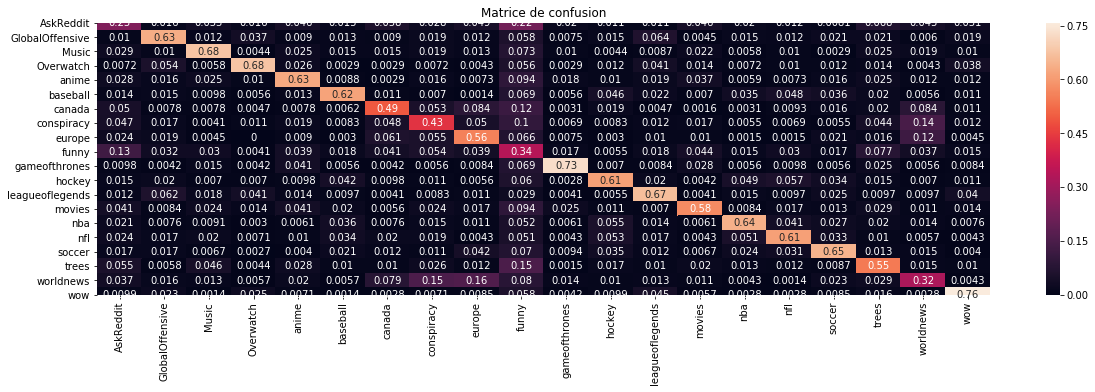

In [58]:
# MLP TRAINING & VALIDATION
train_model(model_MLP.set_params(solver = 'adam', hidden_layer_sizes = (500,), activation = 'logistic', early_stopping = True, learning_rate_init = 0.0001, alpha=0.0001), x_train_tfidf_word, y_train, x_valid_tfidf_word, y_valid)

In [124]:
pred = model_MLP.predict(x_valid_tfidf_word)

print('Precision (macro-avg): ',  precision_score(y_valid, pred, average = 'macro'))
print('Recall (macro-avg): ',  recall_score(y_valid, pred, average = 'macro'))
print('F1 Score (macro-avg): ',  f1_score(y_valid, pred, average = 'macro'))
print('Accuracy: ',  accuracy_score(y_valid, pred))

Precision (macro-avg):  0.588362507258043
Recall (macro-avg):  0.5710195178223443
F1 Score (macro-avg):  0.5775178605077267
Accuracy:  0.5700714285714286


                 precision    recall  f1-score   support

      AskReddit       0.29      0.28      0.28       737
GlobalOffensive       0.62      0.64      0.63       669
          Music       0.68      0.69      0.68       687
      Overwatch       0.72      0.70      0.71       691
          anime       0.61      0.64      0.62       682
       baseball       0.70      0.62      0.66       714
         canada       0.47      0.51      0.49       645
     conspiracy       0.44      0.46      0.45       723
         europe       0.50      0.55      0.53       667
          funny       0.19      0.24      0.21       724
  gameofthrones       0.82      0.73      0.77       711
         hockey       0.66      0.63      0.64       715
leagueoflegends       0.70      0.67      0.68       725
         movies       0.64      0.61      0.62       713
            nba       0.68      0.64      0.66       658
            nfl       0.66      0.61      0.64       701
         soccer       0.72    

VotingClassifier(estimators=[('MLP',
                              MLPClassifier(activation='logistic', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=True,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(500,),
                                            learning_rate='constant',
                                            learning_rate_init=0.0001,
                                            max_iter=300, momentum=0.9,
                                            n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=0,
                                            shuffle=True, so...
                                                     class_weight=None,
                                          

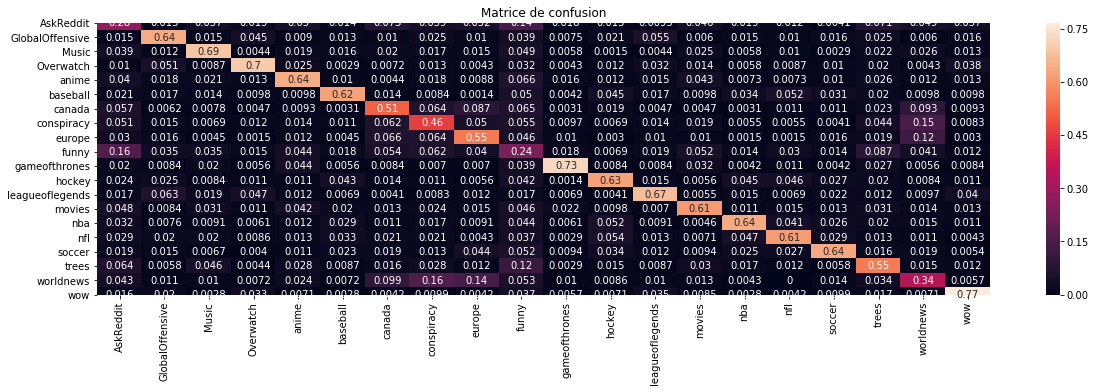

In [130]:
# META ENSEMBLE CLASSIFIER
from sklearn.ensemble import VotingClassifier

model_RF.set_params(n_estimators = 3000, oob_score = True, max_depth = 75)
model_MLP.set_params(solver = 'adam', hidden_layer_sizes = (500,), activation = 'logistic', early_stopping = True, learning_rate_init = 0.0001, alpha=0.0001)
model_NB.set_params(alpha = 0.18)

meta_classifier = VotingClassifier(estimators=[('MLP', model_MLP), ('NB', model_NB), ('RF', model_RF)], voting='soft')
train_model(meta_classifier, x_train_tfidf_word, y_train, x_valid_tfidf_word, y_valid)

In [131]:
pred = meta_classifier.predict(x_valid_tfidf_word)

print('Precision (macro-avg): ',  precision_score(y_valid, pred, average = 'macro'))
print('Recall (macro-avg): ',  recall_score(y_valid, pred, average = 'macro'))
print('F1 Score (macro-avg): ',  f1_score(y_valid, pred, average = 'macro'))
print('Accuracy: ',  accuracy_score(y_valid, pred))

Precision (macro-avg):  0.584038472986594
Recall (macro-avg):  0.5755939466628395
F1 Score (macro-avg):  0.5789434711782967
Accuracy:  0.5745


0.5722857142857143

In [132]:
# generate predictions for the test data
pred = meta_classifier.predict(x_test_tfidf_word)

In [133]:
# export predictions to csv file

import csv

with open('test2.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(['Id', 'Category'])
    i=0
    for word in pred:
        wr.writerow([i, word])
        i+=1

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)